

 <h1>
Welcome to the Math Question Answer Verification Competition! 🚀

The goal is to fine-tune a Llama-3-8B model to predict if a given solution to a math problem is correct or not. Your model should output True if the solution is correct, and False otherwise.

This notebook is a starter guide designed to get you up and running quickly. We'll walk through a simplified training process using a small subset of the data (5,000 examples) and lightweight parameters. The main goal here is to understand the complete workflow, from loading data to generating a submission file, not to achieve a top score.

Good luck, and have fun! 🎉

## **Step 1: Install Necessary Libraries**

First, we need to install the required Python libraries. We'll be using the unsloth library, which provides highly efficient, memory-saving training methods for large language models, making it possible to fine-tune powerful models on a single free-tier GPU. We'll also install xformers for further optimization.


In [1]:
import os
import site
print("Installing unsloth...")
!pip install --quiet "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

# Patch the RL file
site_packages = site.getsitepackages()[0]
rl_file = os.path.join(site_packages, "unsloth", "models", "rl.py")
with open(rl_file, 'r') as f:
    lines = f.readlines()
patched_lines = []
for line in lines:
    if 'align_logprobs_with_mask         = RL_REPLACEMENTS["align_logprobs_with_mask"]' in line:
        patched_lines.append('# ' + line)
        patched_lines.append('align_logprobs_with_mask = None\n')
    elif 'align_logprobs_with_mask_code = inspect.getsource(align_logprobs_with_mask)' in line:
        patched_lines.append('    # ' + line)
        patched_lines.append('    align_logprobs_with_mask_code = ""\n')
    else:
        patched_lines.append(line)
with open(rl_file, 'w') as f:
    f.writelines(patched_lines)
print(" Patch applied!")

import unsloth
import transformers
import trl
print(f" unsloth version: {unsloth.__version__}")
print(f" transformers version: {transformers.__version__}")
print(f" trl version: {trl.__version__}")
print(" Ready to proceed!")

Installing unsloth...
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 276.7/276.7 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.6/132.6 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 54.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 129.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.6/213.6 kB 22.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 25.6.0 requires p

## **Step 2: Load the Model and Tokenizer**

Next, we'll load the Llama-3-8B model, which is the only model permitted for this competition. We'll use Unsloth's FastLanguageModel to handle this efficiently.

A key technique we'll use is 4-bit quantization (load_in_4bit = True). Think of this as compressing the model's knowledge into a much smaller file size. This significantly reduces the amount of GPU memory required, allowing us to fine-tune this large model even on a free platform like Google Colab.



In [2]:
from unsloth import FastLanguageModel
import torch

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = 2048,
    dtype = None,
    load_in_4bit = True,
)
print(" Model loaded: Meta-Llama-3.1-8B")
print(f" Max sequence length: 2048")
print(f" 4-bit quantization: Enabled")

==((====))==  Unsloth 2025.11.1: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

 Model loaded: Meta-Llama-3.1-8B
 Max sequence length: 2048
 4-bit quantization: Enabled


## **Step 3: Prepare the Dataset**

This is a crucial step where we format our data into a structure the model can learn from. The process involves three parts:

1.  **Loading**: We'll load the official competition dataset from Hugging Face.
2.  **Splitting**: The full dataset is massive. For this starter notebook, we'll create a much smaller, more manageable version to speed things up: **40,000 samples for training** and **500 for validation**.
3.  **Prompting**: We will format each data sample into a clear instructional prompt. This helps the model understand its role as a mathematician verifying a solution.



In [3]:
from datasets import load_dataset

# Load full dataset
full_dataset = load_dataset("ad6398/nyu-dl-teach-maths-comp", split="train")

# Shuffle with seed for reproducibility
shuffled_dataset = full_dataset.shuffle(seed=42)

# Use 40K for training, 500 for validation
train_dataset = shuffled_dataset.select(range(40000))
validation_dataset = shuffled_dataset.select(range(40000, 40500))

print(f" Training samples: {len(train_dataset)}")
print(f" Validation samples: {len(validation_dataset)}")
print(f" Dataset columns: {train_dataset.column_names}")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00002.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

data/train-00001-of-00002.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/3.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

 Training samples: 40000
 Validation samples: 500
 Dataset columns: ['question', 'is_correct', 'answer', 'solution']


In [4]:
# CRITICAL: Include the ANSWER field so model can compare!
training_prompt = """### Task: Verify if the solution is correct
Question: {}
Student's Solution:
{}
Correct Answer: {}
Is the student's solution correct?
Answer: {}"""

EOS_TOKEN = tokenizer.eos_token

def formatting_prompts_func(examples):
    questions = examples["question"]
    solutions = examples["solution"]
    answers = examples["answer"]  # THE KEY INGREDIENT!
    outputs = examples["is_correct"]

    texts = []
    for question, solution, answer, output in zip(questions, solutions, answers, outputs):
        # Format each example
        text = training_prompt.format(
            str(question),
            str(solution),
            str(answer),  # This helps the model compare!
            str(output)
        ) + EOS_TOKEN
        texts.append(text)

    return {"text": texts}

# Format both datasets
formatted_train = train_dataset.map(formatting_prompts_func, batched=True, remove_columns=train_dataset.column_names)
formatted_val = validation_dataset.map(formatting_prompts_func, batched=True, remove_columns=validation_dataset.column_names)

print(" Data formatted with ANSWER field included!")
print(f" Example prompt length: ~{len(formatted_train[0]['text'])} characters")

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

 Data formatted with ANSWER field included!
 Example prompt length: ~1051 characters


## **Step 4: Configure LoRA and Set Up the Trainer**

### **LoRA Configuration**

Instead of training the entire model (which has billions of parameters), we'll use a technique called **Lo**w-**R**ank **A**daptation (LoRA). 🎛️

Think of it like this: rather than rewriting an entire textbook, we're just adding small, efficient "sticky notes" (the LoRA adapters) to update the model's knowledge. This is much faster and requires significantly less memory. We'll use a small **rank** (`r = 8`) to keep the training process light and quick for this starter notebook.


In [5]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 8,  # Lower rank = more stable training
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,  # 2 * r
    lora_dropout = 0.05,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 42,
)

print(" LoRA configured:")
print(f"   - Rank: 8 (stable)")
print(f"   - Alpha: 16")
print(f"   - Dropout: 0.05")
print(f"   - Target modules: All attention + FFN layers")

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.11.1 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


 LoRA configured:
   - Rank: 8 (stable)
   - Alpha: 16
   - Dropout: 0.05
   - Target modules: All attention + FFN layers



### **SFTTrainer Setup**

Now we'll set up the `SFTTrainer` (Supervised Fine-tuning Trainer). This is the main tool from the `trl` library that will handle the entire training loop for us. We'll give it our model, tokenizer, dataset, and a set of training instructions, such as the batch size and number of epochs.



In [6]:
from trl import SFTTrainer
from transformers import TrainingArguments

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = formatted_train,
    eval_dataset = formatted_val,
    dataset_text_field = "text",
    max_seq_length = 2048,
    args = TrainingArguments(
        # Output
        output_dir = "outputs",

        # Batch settings
        per_device_train_batch_size = 2,
        per_device_eval_batch_size = 4,
        gradient_accumulation_steps = 4,

        # Training schedule
        num_train_epochs = 4,
        warmup_ratio = 0.05,

        # Learning rate
        learning_rate = 1e-4,
        lr_scheduler_type = "cosine",

        # Optimization
        optim = "adamw_8bit",
        weight_decay = 0.01,
        max_grad_norm = 1.0,

        # Precision
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),

        # Logging & Evaluation
        logging_steps = 100,
        eval_strategy = "steps",
        eval_steps = 500,  # Evaluate every 500 steps

        # Saving (save best model based on eval loss)
        save_strategy = "steps",
        save_steps = 500,
        save_total_limit = 2,
        load_best_model_at_end = True,
        metric_for_best_model = "eval_loss",
        greater_is_better = False,

        # Other
        seed = 42,
        report_to = "none",
    ),
)

print(" Trainer configured:")
print(f"   - Total steps: ~{len(formatted_train) // (2 * 4) * 4} steps")
print(f"   - Evaluates every 500 steps")

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/40000 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=16):   0%|          | 0/500 [00:00<?, ? examples/s]

 Trainer configured:
   - Total steps: ~20000 steps
   - Evaluates every 500 steps


## **Step 5: Start Training\!**

Now, we'll call the `train()` function on our `trainer` object. This will kick off the fine-tuning process. Based on our settings, this will run for one full epoch over our 5,000 examples.

Grab a coffee, as this will take a few minutes\! ☕


In [7]:
trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 40,000 | Num Epochs = 4 | Total steps = 20,000
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 20,971,520 of 8,051,232,768 (0.26% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
500,0.754500,0.755719
1000,0.742100,0.733350
1500,0.731000,0.714660
2000,0.706900,0.698825
2500,0.679600,0.681610
3000,0.676200,0.667543
3500,0.650600,0.649632
4000,0.650400,0.645398
4500,0.629700,0.631849
5000,0.602900,0.618092


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Step,Training Loss,Validation Loss
500,0.754500,0.755719
1000,0.742100,0.733350
1500,0.731000,0.714660
2000,0.706900,0.698825
2500,0.679600,0.681610
3000,0.676200,0.667543
3500,0.650600,0.649632
4000,0.650400,0.645398
4500,0.629700,0.631849
5000,0.602900,0.618092


TrainOutput(global_step=20000, training_loss=0.5140060848236084, metrics={'train_runtime': 47671.9212, 'train_samples_per_second': 3.356, 'train_steps_per_second': 0.42, 'total_flos': 2.429367960610013e+18, 'train_loss': 0.5140060848236084, 'epoch': 4.0})

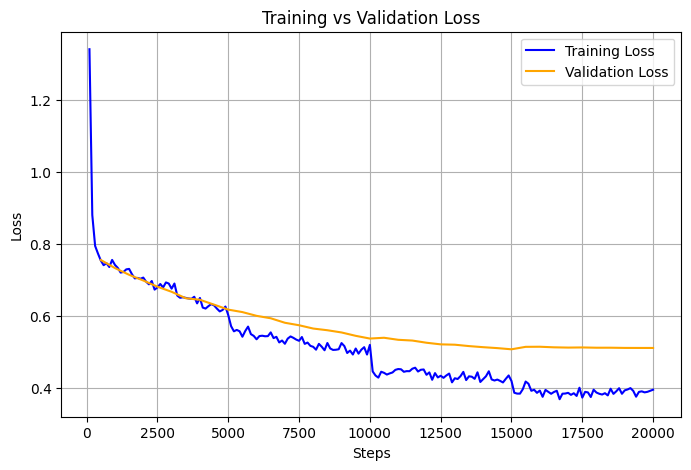

In [ ]:
# Training and Validation Loss Graphs

import matplotlib.pyplot as plt
import pandas as pd

df_logs = pd.DataFrame(trainer.state.log_history)
train_loss = df_logs[df_logs["loss"].notna()][["step", "loss"]]
eval_loss = df_logs[df_logs["eval_loss"].notna()][["step", "eval_loss"]]

plt.figure(figsize=(8,5))
plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss", color="blue")
plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss", color="orange")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()


## **Step 6: Inference and Evaluation**

Now that our model is trained, we need to test it on our validation set. We'll use a slightly different prompt for inference—one where we leave the `Output:` section blank for the model to complete.

Let's test it on a single example from our validation set to see what it predicts.

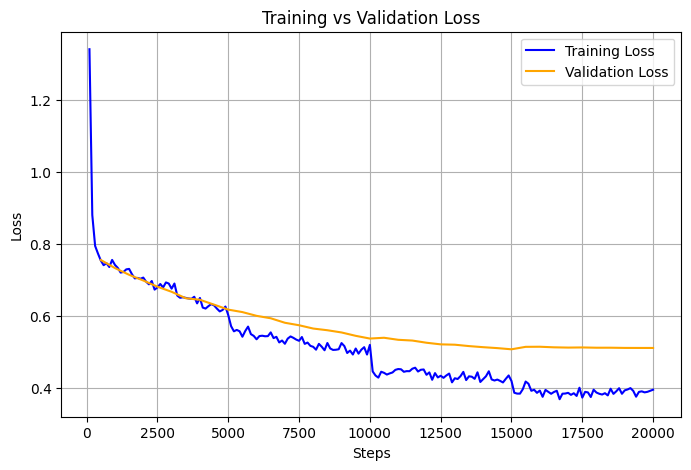

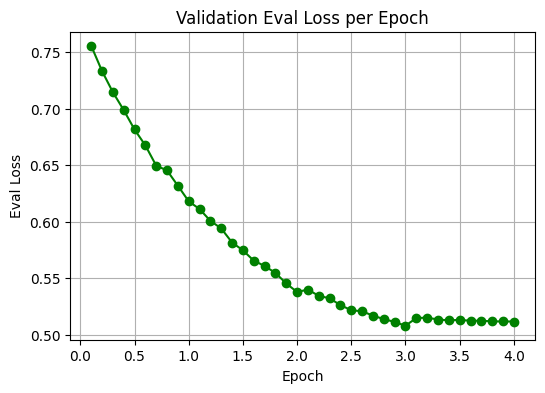

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

df_logs = pd.DataFrame(trainer.state.log_history)

# ---- Training vs Validation Loss ----
if "loss" in df_logs.columns and "eval_loss" in df_logs.columns:
    train_loss = df_logs[df_logs["loss"].notna()][["step", "loss"]]
    eval_loss = df_logs[df_logs["eval_loss"].notna()][["step", "eval_loss"]]

    plt.figure(figsize=(8,5))
    plt.plot(train_loss["step"], train_loss["loss"], label="Training Loss", color="blue")
    plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Validation Loss", color="orange")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(" Loss metrics not found in logs.")

# ---- Epoch metric (Accuracy or Eval Loss) ----
if "eval_accuracy" in df_logs.columns:
    metric_col = "eval_accuracy"
    ylabel = "Accuracy"
elif "eval_loss" in df_logs.columns:
    metric_col = "eval_loss"
    ylabel = "Eval Loss"
else:
    metric_col = None

if metric_col:
    epoch_logs = df_logs[df_logs[metric_col].notna()][["epoch", metric_col]]
    plt.figure(figsize=(6,4))
    plt.plot(epoch_logs["epoch"], epoch_logs[metric_col], marker='o', color='green')
    plt.title(f"Validation {ylabel} per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()
else:
    print(" No validation metric available for plotting.")


 Validation Accuracy (sampled): 0.9850


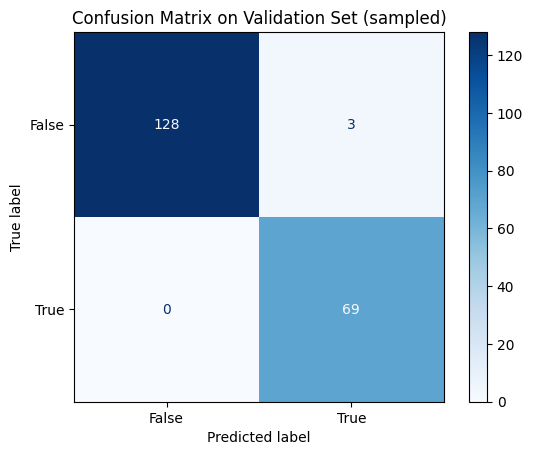

In [ ]:
#  Confusion Matrix on Validation Set

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

val_texts = [ex["text"] for ex in formatted_val]
val_labels = validation_dataset["is_correct"]

preds = []
for text in val_texts[:200]:
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512).to("cuda")
    with torch.no_grad():
        output = model.generate(**inputs, max_new_tokens=10, temperature=0.1, do_sample=False)
    decoded = tokenizer.decode(output[0], skip_special_tokens=True).lower()
    preds.append(True if "true" in decoded else False)

acc = accuracy_score(val_labels[:len(preds)], preds)
print(f" Validation Accuracy (sampled): {acc:.4f}")

cm = confusion_matrix(val_labels[:len(preds)], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["False","True"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix on Validation Set (sampled)")
plt.show()


## **Step 7: Generate Submission File**

This is the final step\! We will now run our fine-tuned model on the official `test` dataset.

We will loop through each example in the test set, generate a prediction, and format the results into a CSV file with two columns: `ID` and `is_correct`, as required by the competition.


In [ ]:
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm

# Switch to inference mode
FastLanguageModel.for_inference(model)

# Load test data
test_dataset = load_dataset("ad6398/nyu-dl-teach-maths-comp", split="test")

# Simpler inference prompt
inference_prompt = """### Task: Verify if the solution is correct
Question: {}
Student's Solution:
{}
Is the student's solution correct?
Answer:"""

predictions = []
print(" Generating predictions...")

for example in tqdm(test_dataset, desc="Processing"):
    # Format prompt
    prompt = inference_prompt.format(
        str(example["question"]),
        str(example["solution"])
    )

    # Tokenize
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    # Generate
    outputs = model.generate(
        **inputs,
        max_new_tokens=10,
        temperature=0.1,  # Low temperature = more confident
        do_sample=False,  # Greedy decoding
        pad_token_id=tokenizer.eos_token_id,
    )

    # Decode
    response = tokenizer.batch_decode(outputs)[0]

    # Parse (look for True/False in response)
    response_lower = response.lower()
    if "true" in response_lower:
        pred = True
    elif "false" in response_lower:
        pred = False
    else:
        # If unclear, default to True (most common)
        pred = True

    predictions.append(pred)

print(f"\n Generated {len(predictions)} predictions")
print(f"   - True: {sum(predictions)}")#
print(f"   - False: {len(predictions) - sum(predictions)}")

# Create submission file
submission = pd.DataFrame({
    'ID': range(len(predictions)),
    'is_correct': predictions
})

# Save to CSV
submission.to_csv('submission.csv', index=False)

print(" Submission file created!")
print(f"   - File: submission.csv")
print(f"   - Rows: {len(submission)}")
print("\n Prediction distribution:")
print(submission['is_correct'].value_counts())

# Download
from google.colab import files
files.download('submission.csv')
print("\n Download started! Submit to Kaggle now!")

🔮 Generating predictions...


Processing: 100%|██████████| 10000/10000 [44:31<00:00,  3.74it/s]


 Generated 10000 predictions
   - True: 3724
   - False: 6276
 Submission file created!
   - File: submission.csv
   - Rows: 10000

 Prediction distribution:
is_correct
False    6276
True     3724
Name: count, dtype: int64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 Download started! Submit to Kaggle now!


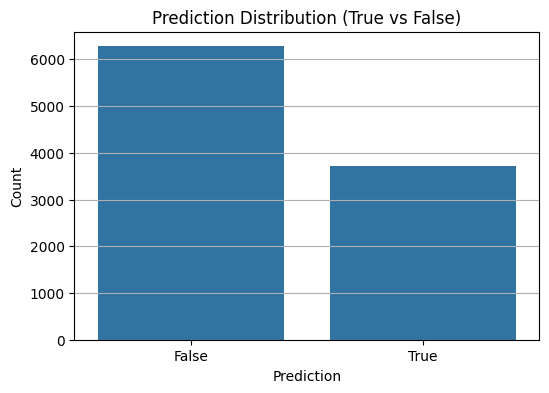

🔍 Sample Predictions:


,ID,is_correct
6252,6252,False
4684,4684,False
1731,1731,True
4742,4742,False
4521,4521,False


In [ ]:

#  Prediction Distribution & Sample Outputs


import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.countplot(x=submission['is_correct'])
plt.title("Prediction Distribution (True vs False)")
plt.xlabel("Prediction")
plt.ylabel("Count")
plt.grid(True, axis='y')
plt.show()

sample_df = submission.sample(5, random_state=42)
print("🔍 Sample Predictions:")
display(sample_df)


# SAVE THE MODEL TO DRIVE AND RUN INFERENCE
Add code to save the model checkpoint to Google Drive, load the model from the checkpoint, and generate the final submission CSV file.

## Mount google drive

### Subtask:
Mount Google Drive to save the model checkpoint.


**Reasoning**:
Mount Google Drive to save the model checkpoint.



In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Save model checkpoint

### Subtask:
Save the trained model checkpoint to the specified path in Google Drive.


**Reasoning**:
Define the save path and save the model and tokenizer to Google Drive.



In [18]:
import os

# Define the path to save the model checkpoint in Google Drive
save_path = "/content/drive/MyDrive/llama3_8b_math_verifier_checkpoint"

# Create the directory if it doesn't exist
os.makedirs(save_path, exist_ok=True)

# Save the model and tokenizer
model.save_pretrained(save_path)
tokenizer.save_pretrained(save_path)

print(f"Model checkpoint and tokenizer saved to: {save_path}")

Model checkpoint and tokenizer saved to: /content/drive/MyDrive/llama3_8b_math_verifier_checkpoint


## Load model from checkpoint

### Subtask:
Load the model from the saved checkpoint.


**Reasoning**:
Load the model and tokenizer from the saved checkpoint path in Google Drive and prepare the model for inference.



In [22]:
# Define the path where the model checkpoint was saved in Google Drive
save_path = "/content/drive/MyDrive/llama3_8b_math_verifier_checkpoint"

# Re-declare the same parameters used during training
max_seq_length = 2048
dtype = None
load_in_4bit = True

# Load the model and tokenizer from the saved path
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = save_path,
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

# Prepare the loaded model for faster inference
FastLanguageModel.for_inference(model)

print(f"Model and tokenizer loaded from: {save_path}")


==((====))==  Unsloth 2025.11.1: Fast Llama patching. Transformers: 4.57.1.
   \\   /|    NVIDIA A100-SXM4-80GB. Num GPUs = 1. Max memory: 79.318 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.8.0+cu126. CUDA: 8.0. CUDA Toolkit: 12.6. Triton: 3.4.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!
Model and tokenizer loaded from: /content/drive/MyDrive/llama3_8b_math_verifier_checkpoint


## Generate submission file

### Subtask:
Generate the submission CSV file using the loaded model.


**Reasoning**:
Generate the submission CSV file by iterating through the test dataset, generating predictions using the loaded model, and saving the results to a pandas DataFrame.



In [23]:
import pandas as pd
from tqdm import tqdm
from datasets import load_dataset

# Load the official test set
test_dataset = load_dataset("ad6398/nyu-dl-teach-maths-comp", split="test")
predictions = []

# Create the prompt template for inference (no answer included)
inference_prompt = """You are a great mathematician and you are tasked with finding if a solution to a given maths question is correct or not. Your response should be 'True' if the solution is correct, otherwise 'False'. Below is the Question and Solution.
Question:
{}
Solution:
{}
Output:
"""

# A simple function to parse 'True' or 'False' from the model's raw output
def parse_output(response_text):
    # Find the text after "Output:"
    output_part = response_text.split("Output:\n")[-1]
    # Check if "True" is in that part, case-insensitively
    if 'true' in output_part.lower():
        return True
    return False

# Loop through the test dataset and generate a prediction for each example
for example in tqdm(test_dataset):
    question = example["question"]
    solution = example["solution"]

    # Format the prompt
    prompt = inference_prompt.format(question, str(solution))
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    # Generate the prediction
    outputs = model.generate(**inputs, max_new_tokens=8, use_cache=True)
    response_text = tokenizer.batch_decode(outputs)[0]

    # Parse the prediction and add it to our list
    prediction = parse_output(response_text)
    predictions.append(prediction)

# Create the submission DataFrame
submission = pd.DataFrame({
    'ID': range(len(predictions)),
    'is_correct': predictions
})

# Save the DataFrame to a CSV file
submission.to_csv('submission.csv', index=False)

print("\nSubmission file 'submission.csv' created successfully!")
print("You can now download this file and submit it to the Kaggle competition.")

100%|██████████| 10000/10000 [1:48:53<00:00,  1.53it/s]


Submission file 'submission.csv' created successfully!
You can now download this file and submit it to the Kaggle competition.
